In [1]:
using PyPlot
using DataFrames
using CSV
import Statistics

In [2]:
include("./src/loop_function.jl")
include("./src/tmat.jl")
include("./src/tmat_up_to_nlo.jl")
include("./src/par.jl")
include("./src/subtraction_cons.jl")

subtraction_cons_tuple (generic function with 1 method)

In [3]:
import PyCall
iminuit = PyCall.pyimport("iminuit");

In [5]:
par_phy_channel = par_physical_channel()
# par_phy_channel[:decons] = 106.0

Dict{Symbol, Any} with 4 entries:
  :threshold  => [1431.95, 1328.94, 1327.62, 1437.22, 1337.02, 1250.66]
  :mch        => [(493.68, 938.272), (139.57, 1189.37), (134.977, 1192.64), (49…
  :meson_mass => (139.57, 134.977, 139.57, 497.65, 493.68)
  :decons     => 100.69

In [9]:
b = (-0.664609603537589, 0.062434962905761365, -0.35384103271852047)
d = (-0.46011427499158786, 0.05501054906425522, -0.06775661407295062, -0.5884345325719142);

In [12]:
D = lec_bi(par_phy_channel, b)
L = lec_di(d);

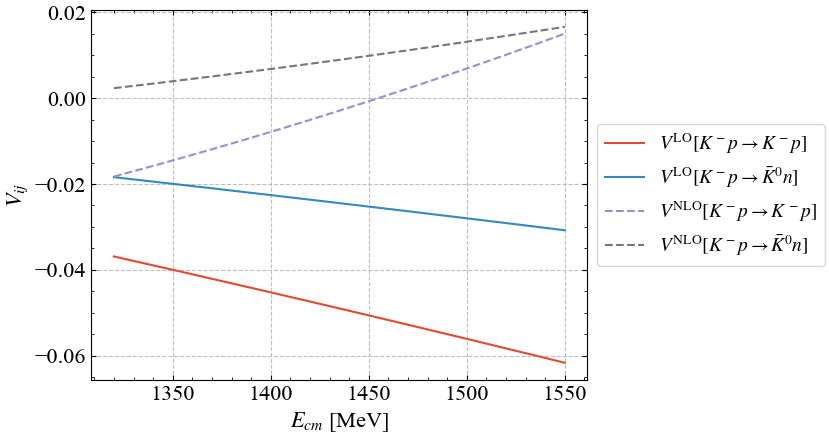

In [34]:
w = 1320:0.01:1550
vnlo11 = [real(vnlo_swave(ww, par_phy_channel, D, L, n=6)[1, 1] ) for ww in w]
vnlo14 = [real(vnlo_swave(ww, par_phy_channel, D, L, n=6)[1, 4] ) for ww in w]

vlo11 = [real(WT(ww, par_phy_channel, lecs_cij(), n=6)[1, 1]) for ww in w]
vlo14 = [real(WT(ww, par_phy_channel, lecs_cij(), n=6)[1, 4]) for ww in w]





fig, ax = PyPlot.subplots()

ax.plot(w, (vlo11), label=L"V^{\mathrm{LO}}[K^- p \to K^- p]")
ax.plot(w, (vlo14), label=L"V^{\mathrm{LO}}[K^- p \to \bar{K}^0 n]")

ax.plot(w, vnlo11, ls="--", label=L"V^{\mathrm{NLO}}[K^- p \to K^- p]")
ax.plot(w, vnlo14, ls="--", label=L"V^{\mathrm{NLO}}[K^- p \to \bar{K}^0 n]")
ax.legend(loc = "center left", bbox_to_anchor=(1, 0.5))
ax.set(xlabel=L"$E_{cm}$ [MeV]", ylabel=L"V_{ij}")
ax.grid()
fig

In [35]:
D, F = 0.8, 0.46;

In [36]:
function VD(w, par, Mi, Mj, Mk)
    s = w*w
    f = par[:decons]
    Ni = norm_factor(w, Mi)
    Nj = norm_factor(w, Mj)
    return -1. / (12e0f^2) * Ni * Nj * (w - Mi)*(w-Mk)*(w-Mj) / (s - Mk^2)
end

function VD11(w, par, Mi, Mj, Mk1, Mk2)
    CΛ = -D - 3e0F
    CΣ = sqrt(3.)(D - F)
    return CΛ^2 * VD(w, par, Mi, Mj, Mk1) + CΣ^2 * VD(w, par, Mi, Mj, Mk2)
end
function VD14(w, par, Mi, Mj, Mk1, Mk2)
    CΛ = -D - 3e0F
    CΣ1 = sqrt(3.) * (D - F)
    CΣ2 = -sqrt(3.) * (D - F)
    return CΛ^2 * VD(w, par, Mi, Mj, Mk1) + CΣ1 * CΣ2 * VD(w, par, Mi, Mj, Mk2)
end

mp = 938.272
mn = 939.565
mLam = 1115.68
mSig0 = 1192.64;